In [2]:
import numpy as np
import artm
from dataset_500 import DataReader

dataset = DataReader().fetch_data()
x, y = dataset.train_data

Data loading started...
data has been loaded!


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import numpy as np

n_features = 2000
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=n_features,
                             stop_words='english')

tfidf = vectorizer.fit_transform(x)
feature_names = vectorizer.get_feature_names()

In [ ]:
print(tfidf.shape[0], tfidf.shape[1])
print(tfidf.transpose())

In [6]:
M = tfidf.transpose
f = open('termdoc.txt', 'w', encoding = 'utf-8')
for i in range(tfidf.shape[0]):
    f.write('doc'+str(i))
    for j in range(tfidf.shape[1]):
        if(tfidf[i,j]>0):
            f.write(' '+feature_names[j]+':'+str(tfidf[i,j]))
    f.write('\n')
f.close()

In [124]:
batch_vectorizer = artm.BatchVectorizer(data_path='termdoc.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches_transactions_data', gather_dictionary = True)

print(batch_vectorizer.dictionary)
model = artm.ARTM(num_topics=40, dictionary=batch_vectorizer.dictionary, cache_theta=True)


model.scores.add(artm.PerplexityScore(name='perplexity_score',
                                      dictionary=batch_vectorizer.dictionary))
model.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score'))
model.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
model.scores.add(artm.TopTokensScore(name='top_tokens_score'))

artm.Dictionary(name=3aa78f2d-9abb-4398-a87a-08c141d81a21, num_entries=2000)


# regularizator 1

In [125]:
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='sparse_phi_regularizer'), overwrite=True)
model.regularizers['sparse_phi_regularizer'].tau = 0.01

# regularizator 2

In [126]:
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='sparse_theta_regularizer'), overwrite=True)
model.regularizers['sparse_theta_regularizer'].tau = 0.01

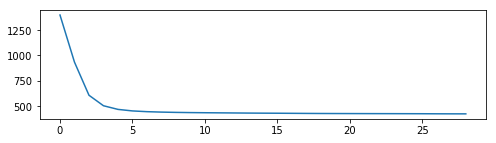

In [127]:
import matplotlib.pyplot as plt
%matplotlib inline

model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)
perp_values = model.score_tracker['perplexity_score'].value[1:]
plt.figure(figsize=(8,2))
plt.plot(perp_values)

In [111]:
model.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=30)
tokens = model.score_tracker['top_tokens_score'].last_tokens
for topic_name in model.topic_names:
    print('{}:'.format(topic_name)),
    for token in tokens[topic_name]:
        print(token)
    print('\n')

topic_0:
twitter
tax
francisco
companies
san
city
employees
bloomberg
stock
company


topic_1:
silk
hostages
held
collection
buzz
clean
care
benefits
hand
story


topic_2:
actress
star
cruz
penelope
hollywood
depp
oscar
coral
bp
fame


topic_3:
google
search
android
microsoft
app
youtube
phones
bottles
plastic
phone


topic_4:
game
goal
ball
calipari
season
games
coach
ncaa
england
play


topic_5:
day
dodgers
phillies
christie
said
single
left
hit
opening
mets


topic_6:
calorie
calories
fda
information
menus
restaurants
menu
movie
apply
restaurant


topic_7:
obama
republicans
government
budget
party
china
house
republican
federal
cuts


topic_8:
ouattara
gbagbo
forces
abidjan
military
said
ivory
libyan
coast
northampton


topic_9:
teacher
dress
school
gaga
kate
students
lady
paterson
facebook
fashion


topic_10:
video
minister
charged
nuclear
alleged
plant
saturday
new
indian
power


topic_11:
police
man
car
killed
arrested
officer
launch
charged
daughter
daisy


topic_12:
franco
film

In [130]:
phi = model.get_phi()
theta = model.get_theta()
#print(phi)
#print(theta)

In [131]:
snum = 0
sjac = 0
N_docs = len(x)
for i in range(N_docs):
    indmax = theta[i].argmax()
    ans = phi.nlargest(40, indmax).index.values.tolist()
    snum += len(set(map(lambda x : x.lower(), y[i])) & set(ans))
    if(len(set(ans))!=40):
        print(len(set(ans)))
    real_ans = set(map(lambda x : x.lower(), y[i]))
    sjac += len(real_ans & set(ans))/len(real_ans | set(ans))
print(snum/N_docs)
print(sjac/N_docs)

4.475555555555555
0.05407007933982673
